In [1]:
%pip install torch
%pip install torcheval
%pip install scikit-learn
%pip install einops
%pip uninstall -y guorbit-utils
%pip install git+https://github.com/guorbit/utilities.git@dev_dataloader_filetype_ext
%pip install boto3
%pip install wandb
%pip install pytorch-msssim


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/6d/13/b5e8bacd980b2195f8a1741ce11cbb9146568607795d5e4ff510dcff1064/torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/5e/5d/97afbafd9d584ff1b45fcb354a479a3609bd97f912f8f1f6c563cb1fae21/filelock-3.12.4-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 91.8 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 126.2 MB/s eta 0:00:00
  Obtaining dependency information for fsspec from https://files.pythonhosted.org/packages/fe/d3/e1aa96437d944fbb9cc95d0316e25583886e9cd9e6adc07baad943524eda/fsspec-2023.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import boto3
from concurrent.futures import ThreadPoolExecutor
import io

In [2]:
from urllib3.exceptions import IncompleteRead
class MultipartDownloader:
    def __init__(self, bucket, key, part_size=100*1024*1024):
        self.s3_client = boto3.client(
            "s3",
            endpoint_url="https://8399b55f39118db974decacec50abde3.r2.cloudflarestorage.com",
            aws_access_key_id="e581f44cdeaccb0732d7e16af703bb5d",
            aws_secret_access_key="ffdbba3b2062dcc9d7cf5f598df59c0da88804efbcc30f0cb0b891cdfb520aa5",
            config=boto3.session.Config(
                signature_version="s3v4",
                read_timeout=60 * 3,
                ),
        )
        self.bucket = bucket
        self.key = key
        self.part_size = part_size

    def download_part(self, part_number, retries=3):
        start_byte = (part_number - 1) * self.part_size
        end_byte = start_byte + self.part_size - 1
        range_header = f"bytes={start_byte}-{end_byte}"
        
        for _ in range(retries):
            try:
                response = self.s3_client.get_object(Bucket=self.bucket, Key=self.key, Range=range_header)
                body = response['Body'].read()
                return start_byte, body
            except IncompleteRead as e:
                print(f"Retrying part {part_number} due to IncompleteRead: {e}")
        raise Exception(f"Failed to download part {part_number} after {retries} retries")


    def download(self):
        # Get the size of the object
        response = self.s3_client.head_object(Bucket=self.bucket, Key=self.key)
        object_size = response['ContentLength']
        
        # Calculate the number of parts
        num_parts = -(-object_size // self.part_size)  # Ceiling division
        
        # Download each part in parallel
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.submit(self.download_part, part_number)
                for part_number in range(1, num_parts + 1)
            ]
            
        # Collect the parts into a bytearray
        data = bytearray(object_size)
        for future in futures:
            start_byte, part_data = future.result()
            data[start_byte:start_byte + len(part_data)] = part_data
        
        return data

In [4]:
data = MultipartDownloader("paperspace-bucket",f"bhsi/pb_tr/image/batch_0.npy").download()
batch = np.load(io.BytesIO(data))

In [5]:
# run forward pass
n = 2
img = batch[n].copy()
img = np.moveaxis(img, -1, 0)



In [6]:
def compute_covariance_matrix(batch):
    batch_size = batch.shape[0]
    data = np.moveaxis(batch, -1, 1)
    data = data/255
    mean_spectrum = np.mean(data, axis=(2, 3))

    # Subtract the mean spectrum from each pixel
    data_centered = data - mean_spectrum[:, :, np.newaxis, np.newaxis]

    # Reshape the data into a 2D array
    data_2d = data_centered.reshape((batch_size, -1, 32))

    # Compute the covariance matrix for each image in the batch
    covariance_matrices = []
    for i in range(batch_size):
        covariance_matrix = np.cov(data_2d[i].T)
        covariance_matrices.append(covariance_matrix)

    return np.array(covariance_matrices)

def combine_covariance_matrices(covariance_matrices):
    num_images = covariance_matrices.shape[0]
    combined_covariance_matrix = np.sum(covariance_matrices, axis=0) / num_images
    return combined_covariance_matrix

# Example usage

covariance_matrices = compute_covariance_matrix(batch)
combined_covariance_matrix = combine_covariance_matrices(covariance_matrices)
print(combined_covariance_matrix)


[[0.01055826 0.00901112 0.00771851 ... 0.00275715 0.00273564 0.00263974]
 [0.00901112 0.01055697 0.00901533 ... 0.00287133 0.00286236 0.00277216]
 [0.00771851 0.00901533 0.01066478 ... 0.00303726 0.00303331 0.00293211]
 ...
 [0.00275715 0.00287133 0.00303726 ... 0.01042188 0.00898322 0.00770171]
 [0.00273564 0.00286236 0.00303331 ... 0.00898322 0.01050604 0.00902207]
 [0.00263974 0.00277216 0.00293211 ... 0.00770171 0.00902207 0.01052471]]


In [7]:
data = batch[n].copy()
data = np.moveaxis(data, -1, 0)
data = data/255
mean_spectrum = np.mean(data, axis=(0, 1))

# Subtract the mean spectrum from each pixel
data_centered = data - mean_spectrum

# Reshape the data into a 2D array
data_2d = data_centered.reshape((-1, 32))

# Compute the covariance matrix
covariance_matrix = np.cov(data_2d.T)

print(covariance_matrix)

[[0.01593026 0.01341528 0.01185387 ... 0.00826598 0.00904725 0.00763337]
 [0.01341528 0.01355528 0.01210263 ... 0.00863424 0.0094328  0.00839019]
 [0.01185387 0.01210263 0.01239246 ... 0.009188   0.01000939 0.00906815]
 ...
 [0.00826598 0.00863424 0.009188   ... 0.01528621 0.0148819  0.01342029]
 [0.00904725 0.0094328  0.01000939 ... 0.0148819  0.01886717 0.01622989]
 [0.00763337 0.00839019 0.00906815 ... 0.01342029 0.01622989 0.01846847]]


(32, 32)


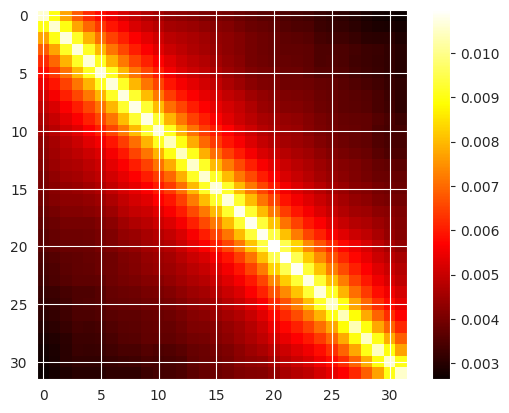

In [8]:
print(combined_covariance_matrix.shape)
plt.imshow(combined_covariance_matrix, cmap='hot')
plt.colorbar()
plt.show()

In [9]:
def eigenvalue_ratio(data, threshold=0.01):
    cov_matrix = np.cov(data, rowvar=False)
    eigenvalues, _ = np.linalg.eig(cov_matrix)
    eigenvalues = np.sort(eigenvalues)[::-1]
    
    total = np.sum(eigenvalues)
    ratios = eigenvalues / total
    num_endmembers = np.sum(ratios > threshold)
    
    return num_endmembers

data_flat = data.copy()
data_flat = data_flat.reshape(-1, data.shape[-1])
n_endmembers=eigenvalue_ratio(data_flat)
print(n_endmembers)

9


In [10]:

from sklearn.decomposition import FastICA
data_new = data.copy()
# Assuming hsi_data is your hyperspectral image data
# Reshape the data to 2D array
data_2d = data_new.reshape(-1, data_new.shape[0])
print(data_2d.shape)

# Perform ICA
ica = FastICA(n_components=n_endmembers)  # Assuming 4 endmembers
S_ = ica.fit_transform(data_2d)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix, which contains the endmembers

# Each column of A_ is an endmember
endmembers = A_.T


(4096, 32)


In [11]:
def linear_spectral_unmixing(hsi_data, endmembers):
    """
    Perform Linear Spectral Unmixing on Hyperspectral Image Data.
    
    Parameters:
    hsi_data (numpy array): Hyperspectral image data of shape (bands, rows, cols).
    endmembers (numpy array): Endmember signatures of shape (num_endmembers, bands).
    
    Returns:
    numpy array: Abundance maps of shape (rows, cols, num_endmembers).
    """
    # Get dimensions of the hyperspectral image data
    bands, rows, cols = hsi_data.shape
    
    print(f"rows {rows}, cols {cols}, bands {bands}")
    
    # Ensure endmembers matrix is oriented correctly (bands, num_endmembers)
    if endmembers.shape[1] != bands:
        endmembers = endmembers.T
        
    num_endmembers = endmembers.shape[0]
    
    print(f"num_endmembers {num_endmembers}")

    # Reshape the hyperspectral image data to 2D array (pixels, bands)
    hsi_data_2d = hsi_data.transpose(1, 2, 0).reshape(-1, bands)
    
    print(f"hsi_data_2d {hsi_data_2d.shape}")

    # Calculate the pseudo-inverse of the endmember matrix
    endmembers_pinv = np.linalg.pinv(endmembers)

    print(f"endmembers_pinv {endmembers_pinv.shape}")
    
    # Perform the unmixing
    abundance_maps_2d = np.dot(hsi_data_2d, endmembers_pinv)

    print(f"abundance_maps_2d {abundance_maps_2d.shape}")
    
    # Apply constraints (ensure non-negativity and sum-to-one)
    abundance_maps_2d = np.clip(abundance_maps_2d, 0, None)  # Non-negativity
    sum_abundance = np.sum(abundance_maps_2d, axis=1, keepdims=True)
    abundance_maps_2d = abundance_maps_2d / sum_abundance  # Sum-to-one
    
    # Reshape the abundance maps to 3D array (rows, cols, num_endmembers)
    abundance_maps = abundance_maps_2d.reshape(rows, cols, num_endmembers)
    
    return abundance_maps

print(data.shape)
print(endmembers.shape)
# Usage:
# Assume hsi_data is your hyperspectral image data and endmembers is your endmember signatures matrix
abundance_maps = linear_spectral_unmixing(data, endmembers)


(32, 64, 64)
(9, 32)
rows 64, cols 64, bands 32
num_endmembers 9
hsi_data_2d (4096, 32)
endmembers_pinv (32, 9)
abundance_maps_2d (4096, 9)


(64, 64, 9)


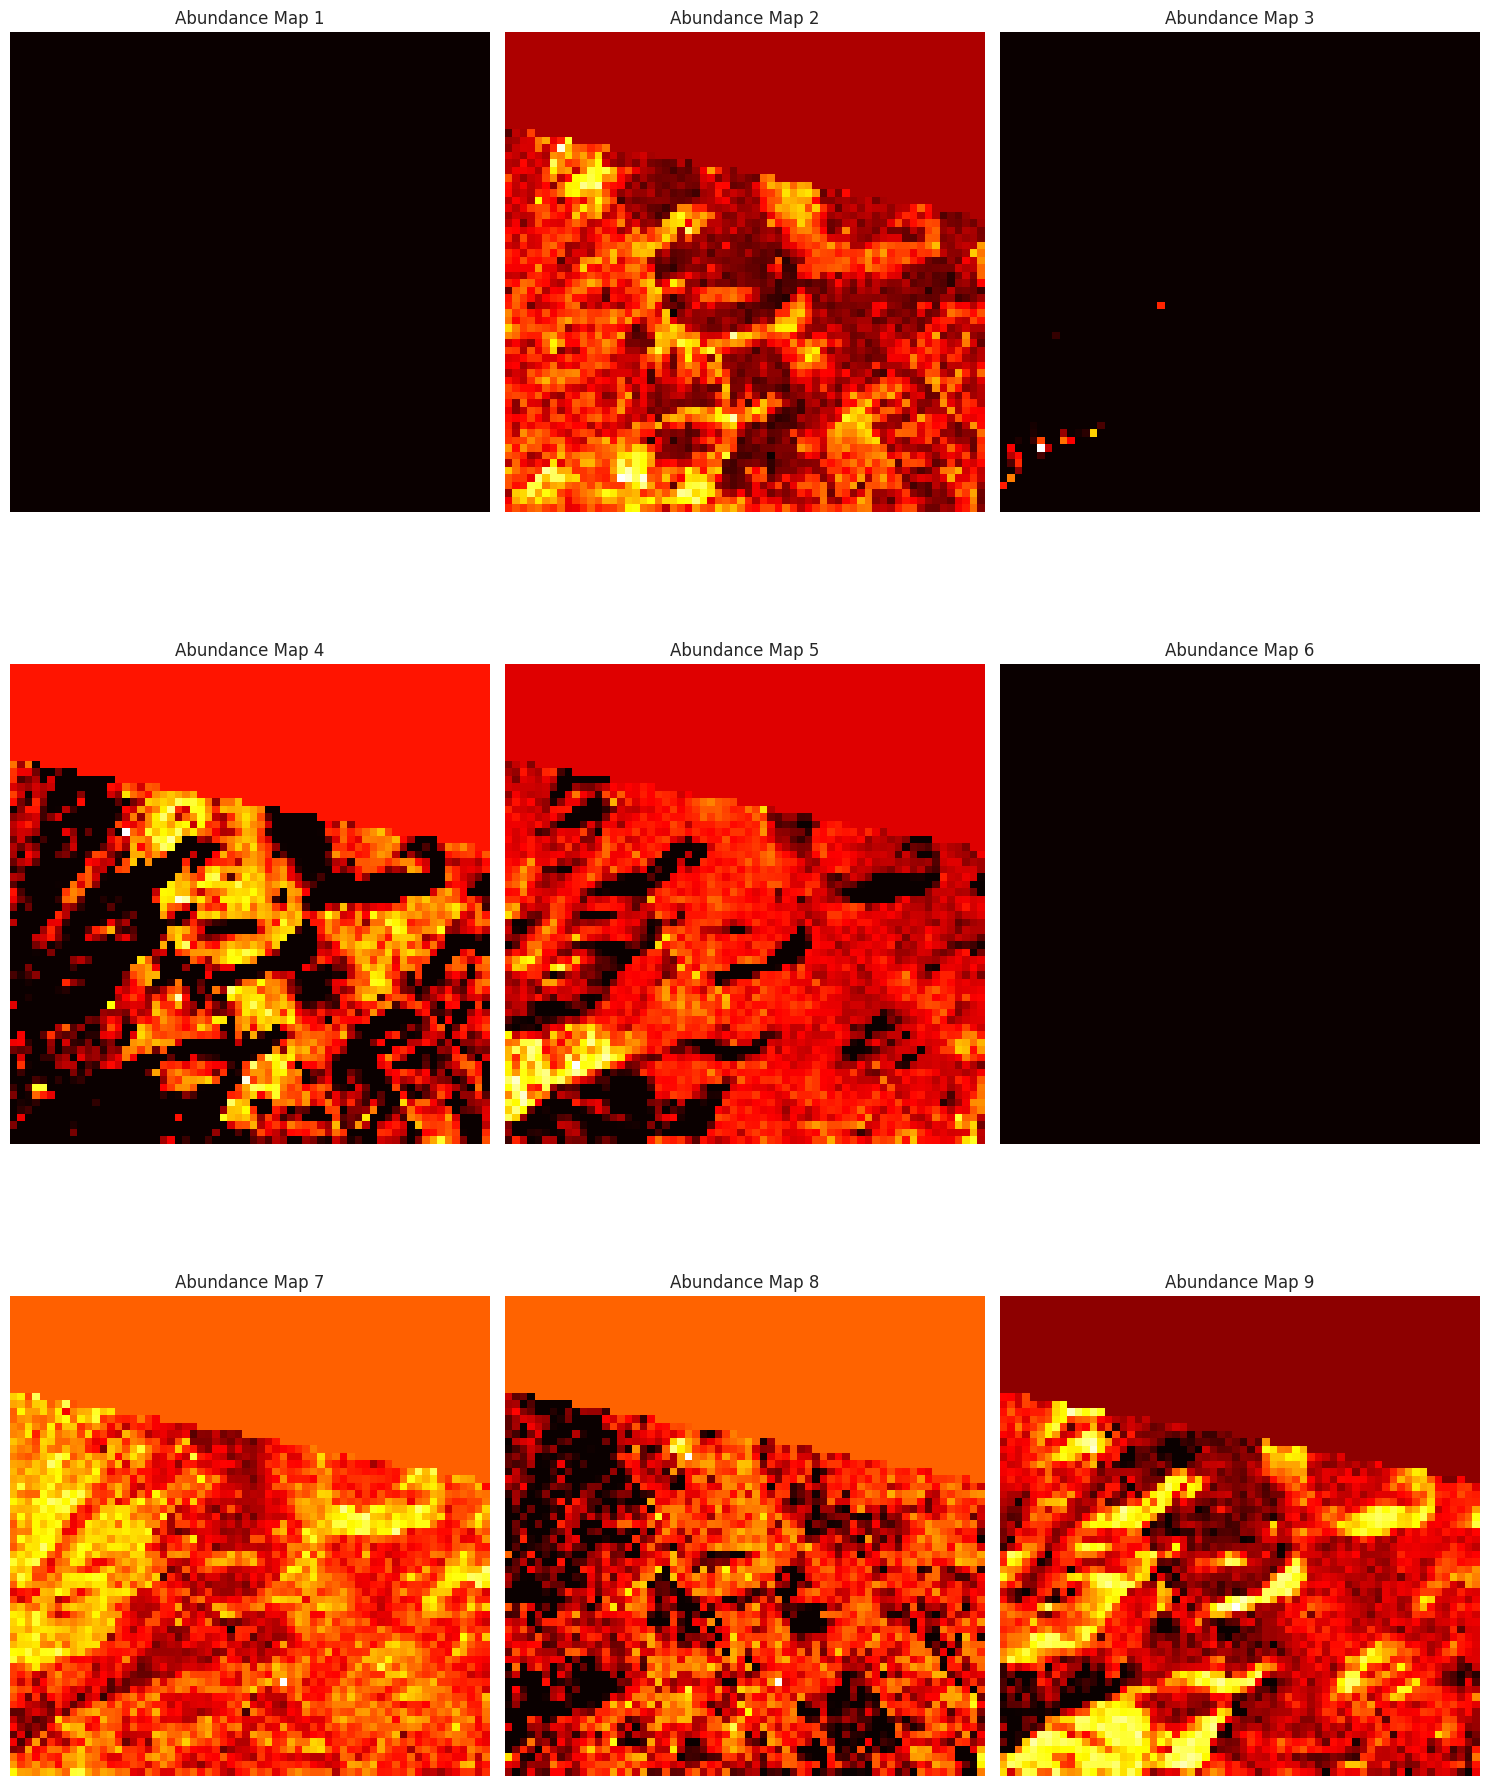

(64, 64, 9)


In [12]:
print(abundance_maps.shape)

def visualize_abundance_maps(abundance_maps):
    num_endmembers = abundance_maps.shape[-1]
    row = int(np.sqrt(num_endmembers))
    col = int(np.ceil(num_endmembers / row))
    
    

    fig, axs = plt.subplots(row,col , figsize=(15, 20))
    
    for i in range(row):
        n_cols = num_endmembers - i * col
        n_cols = min(n_cols, col)
        for j in range(n_cols):
            ax = axs[i, j]
            abundance_map_index = i * col + j
            abundance_map = abundance_maps[:, :, abundance_map_index]
            ax.imshow(abundance_map, cmap='hot')
            ax.set_title(f'Abundance Map {abundance_map_index + 1}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage:
# Assume abundance_maps is the output from your linear spectral unmixing function
visualize_abundance_maps(abundance_maps)
print(abundance_maps.shape)

In [27]:
# brihgtness distribution at channel 0
mask = np.where(batch[n] < 0 , True, False)
    
print(batch[n].min())
print(batch[n].max())
brightnesses = batch[n].copy()
std_per_band = np.array([
    33.48886853, 33.22482796, 33.4670978,  33.53758141, 33.48675988, 33.33348355,
    33.35096189, 33.63958817, 33.85081288, 34.08314358, 34.37542553, 34.60344274,
    34.80732573, 35.17761688, 35.1956623,  34.43121367, 33.76600779, 33.77061146,
    33.92844916, 34.0370747,  34.0285642,  33.87601205, 33.81035869, 33.66611756,
    33.74440912, 33.69755911, 33.69845938, 33.6707364,  33.62571536, 33.44615438,
    33.27907802, 32.90732107
])


mean_per_band = np.array([
    136.43702139, 136.95781982, 136.70735693, 136.91850906, 137.12465157,
    137.26050865, 137.37743316, 137.24835798, 137.04779119, 136.9453704,
    136.79646442, 136.68328908, 136.28231996, 136.02395119, 136.01146934,
    136.72767901, 137.38975674, 137.58604882, 137.61197314, 137.46675538,
    137.57319831, 137.69239868, 137.72318172, 137.76894864, 137.74861655,
    137.77535075, 137.80038781, 137.85482571, 137.88595859, 137.9490434,
    138.00128494, 138.17846624
])
def normalize_image(image, mean, std,seed=0):
    """
    Normalize a multi-channel image using per-channel mean and standard deviation.
    
    Parameters:
        image (numpy.ndarray): The image to be normalized. Shape should be (height, width, channels).
        mean (list or numpy.ndarray): The mean values for each channel.
        std (list or numpy.ndarray): The standard deviation values for each channel.
        
    Returns:
        numpy.ndarray: The normalized image.
    """
    # Ensure mean and std are numpy arrays
    # Normalize each channel

    normalized_image = (image - mean) / std

    return normalized_image

brightnesses = normalize_image(brightnesses, mean_per_band, std_per_band)
delta = np.min(brightnesses)
print(delta)
brightnesses-=delta
brightnesses*=100
print(brightnesses.min(), brightnesses.max())
brightnesses = np.round(brightnesses).astype(np.uint8)
brightnesses = np.bincount(brightnesses.reshape(64*64, 32)[:,2])
brightness_dist = np.zeros(256)
for i in range(min(brightnesses.shape[0],256)):
    brightness_dist[i] = brightnesses[i]
print(brightness_dist)
print(brightness_dist.shape)


71
240
-2.0133155401641143
0.0 504.6083627201807
[1.600e+01 0.000e+00 0.000e+00 1.800e+01 0.000e+00 0.000e+00 1.300e+01
 0.000e+00 0.000e+00 1.800e+01 0.000e+00 1.204e+03 1.000e+01 0.000e+00
 0.000e+00 7.000e+00 0.000e+00 0.000e+00 9.000e+00 0.000e+00 0.000e+00
 6.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 6.000e+00
 0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 6.000e+00 0.000e+00
 0.000e+00 7.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00
 5.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 4.000e+00
 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00
 0.000e+00 6.000e+00 0.000e+00 0.000e+00 3.000e+00 0.000e+00 0.000e+00
 3.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00
 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00
 7.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 5.000e+00
 0.000e+00 0.000e+00 1.000e+

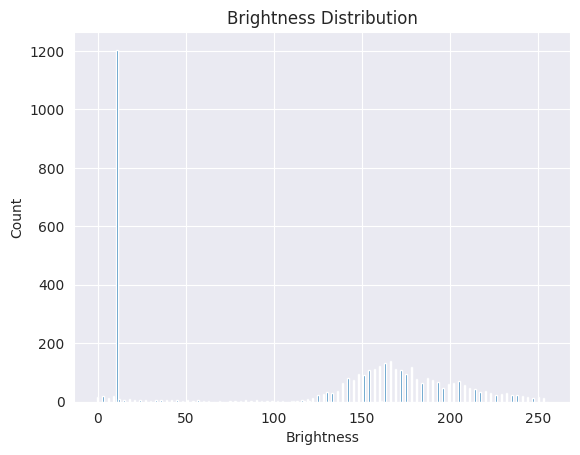

In [28]:
#plot brightness distribution
plt.bar(np.arange(256), brightness_dist)
plt.title('Brightness Distribution')
plt.xlabel('Brightness')
plt.ylabel('Count')
plt.show()